In [1]:
!pip install tensorflow==2.4.1 opencv-python matplotlib

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Layer,Conv2D,MaxPooling2D,Flatten

In [4]:
#create folders for dataset 
Pos_Path=os.path.join('data','POS')
Neg_Path=os.path.join('data','NEG')
Anch_Path=os.path.join('data','ANCH')

In [5]:
paths=[Pos_Path,Neg_Path,Anch_Path]
for path in paths:
    if not os.path.exists(path):
        if os.name=='nt':
            !mkdir  {path}
        if os.name=='posix':
            !mkdir -p {path}

In [9]:
for directory in os.listdir('lfw'):
    directory_path = os.path.join('lfw', directory)
    for file in os.listdir(directory_path):
        EX_path_file = os.path.join(directory_path, file)
        New_path_file = os.path.join('data', 'NEG', file)
        os.replace(EX_path_file, New_path_file)

In [11]:
import cv2
import uuid

In [33]:

cap = cv2.VideoCapture(0)

print("Press 'a' to save to ANCH, 'p' to save to POS, 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to read frame.")
        break

    # Resize frame to 250x250
    frame_resized = cv2.resize(frame, (250, 250))

    # Show the frame
    cv2.imshow('Capture (press a/p/q)', frame_resized)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('a'):
        filename = f"{uuid.uuid1()}.jpg"
        filepath = os.path.join(Anch_Path, filename)
        cv2.imwrite(filepath, frame_resized)
      

    elif key == ord('p'):
        filename = f"{uuid.uuid1()}.jpg"
        filepath = os.path.join(Pos_Path, filename)
        cv2.imwrite(filepath, frame_resized)
       


    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Press 'a' to save to ANCH, 'p' to save to POS, 'q' to quit.


In [13]:
# Load datasets
anchor    = tf.data.Dataset.list_files(Anch_Path + '/*.jpg').take(300)
positive  = tf.data.Dataset.list_files(Pos_Path + '/*.jpg').take(300)
negative  = tf.data.Dataset.list_files(Neg_Path + '/*.jpg').take(300)


In [14]:

# Create label datasets
positive_labels = tf.data.Dataset.from_tensor_slices(tf.ones(300, dtype=tf.float32))
negative_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(300, dtype=tf.float32))



In [15]:
# Zip into (anchor, positive/negative, label)
positives = tf.data.Dataset.zip((anchor, positive, positive_labels))
negatives = tf.data.Dataset.zip((anchor, negative, negative_labels))

In [19]:
# Concatenate
data_set = positives.concatenate(negatives)

In [21]:
samples=data_set.as_numpy_iterator()

In [23]:
samples.next()

(b'data\\ANCH\\cb644234-3eed-11f0-b895-a83b76ee2ca2.jpg',
 b'data\\POS\\103a77ae-3eee-11f0-994d-a83b76ee2ca2.jpg',
 1.0)

In [25]:
# Step 3: Preprocess function
def load_and_preprocess_image(image_path):
    # Resize, normalize, and expand dims
    byte_img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))  # adapt to your input size
    img = img / 255.0
    return img

In [27]:
def double_images(image_input,image_ref,label):
    return(load_and_preprocess_image(image_input),load_and_preprocess_image(image_ref),label)

In [29]:
data_set=(
    data_set
    .shuffle(buffer_size=1024)
    .map(double_images)
    .prefetch(8)
)


In [31]:
train_data_set_len=len(data_set)*0.7

In [33]:
BATCH_SIZE = 16

train_dataset = data_set.take(int(train_data_set_len)) \
                        .shuffle(buffer_size=1000) \
                        .batch(BATCH_SIZE) \
                        .prefetch(8)

In [35]:
test_dataset = data_set.skip(int(train_data_set_len)) \
                        .shuffle(buffer_size=1000) \
                        .batch(BATCH_SIZE) \
                        .prefetch(8)            

In [37]:
samples=train_dataset.as_numpy_iterator()

In [40]:
def make_embeddings():
    inp=Input(shape=(100,100,3),name='input_image')   
    #first embedding block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding="same")(c1)
    #Second embedding block
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding="same")(c2)
    #third embedding block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding="same")(c3)
    #Final embedding block
    c4=Conv2D(filters=256,kernel_size=(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    return Model(inputs=[inp],outputs=[d1],name="embedding_layers")

In [42]:
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [44]:
def siamese_neural_network():
    input_image=Input(shape=(100,100,3),name="input_image")
    validation_image=Input(shape=(100,100,3),name="validation_image")

    embedding_network=make_embeddings()

    input_embedding = embedding_network(input_image)
    validation_embedding = embedding_network(validation_image)
    
    l1_layer=L1Dist()
    dist_output = l1_layer(input_embedding, validation_embedding)

    output =Dense(1, activation='sigmoid')(dist_output)


    return Model(inputs=[input_image, validation_image], outputs=output)



In [46]:
siamese_model=siamese_neural_network()

In [48]:
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_image (InputLayer)   [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding_layers (Functional)   (None, 4096)         38960448    input_image[0][0]                
                                                                 validation_image[0][0]           
__________________________________________________________________________________________________
l1_dist (L1Dist)                (None, 4096)         0           embedding_layers[0][0]       

In [50]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001
train_accuracy = tf.keras.metrics.BinaryAccuracy()

In [54]:
checkpoints_dir=os.path.join('.','training_checkpoint')
checkpoint_prefix=os.path.join(checkpoints_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)
os.makedirs(checkpoints_dir)
os.makedirs(checkpoint_prefix)

In [56]:
@tf.function
def train_step(batch):
    # Unpack the batch
    x_anchor, x_other, y_true = batch

    with tf.GradientTape() as tape:
        # Forward pass through Siamese model
        y_pred = siamese_model((x_anchor, x_other), training=True)

        # Compute loss
        loss = binary_cross_loss(y_true, y_pred)
    print(loss)

    # Compute gradients
    gradients = tape.gradient(loss, siamese_model.trainable_variables)

    # Apply gradients
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss

In [58]:
def train(data,EPOCHS):
    for epoch in range(EPOCHS+1):
        print('\n EPOCH {}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))

        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [60]:
EPOCHS=20

train(train_dataset,EPOCHS)


 EPOCH 0/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 10s 216ms/step

 EPOCH 1/20
27/27 [==============================] - 6s 205ms/step

 EPOCH 2/20
27/27 [==============================] - 6s 206ms/step

 EPOCH 3/20
27/27 [==============================] - 6s 205ms/step

 EPOCH 4/20
27/27 [==============================] - 6s 206ms/step

 EPOCH 5/20
27/27 [==============================] - 6s 205ms/step

 EPOCH 6/20
27/27 [==============================] - 6s 206ms/step

 EPOCH 7/20
27/27 [==============================] - 6s 206ms/step

 EPOCH 8/20
27/27 [==============================] - 6s 204ms/step

 EPOCH 9/20
27/27 [==============================] - 6s 204ms/step

 EPOCH 10/20
27/27 [==============================] - 6s 204ms/step

 EPOCH 11/20
27/27 [==============================] - 6s 204ms/step

 EPOCH 12/20
27/27 [======

In [62]:
#import metrics(precision,Recall)
from tensorflow.keras.metrics import Precision,Recall

In [64]:
test_input,test_val,y_true=test_dataset.as_numpy_iterator().next()

In [66]:
y_true

array([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [68]:
y_pred=siamese_model.predict([test_input,test_val])

In [70]:
y_pred

array([[1.0053723e-11],
       [1.0000000e+00],
       [1.6092331e-11],
       [9.9999976e-01],
       [4.8729678e-09],
       [9.9999917e-01],
       [1.1604532e-09],
       [2.0395810e-10],
       [2.9567009e-11],
       [1.0000000e+00],
       [7.8740757e-11],
       [9.9999905e-01],
       [5.2087543e-08],
       [2.8918196e-11],
       [7.7486928e-10],
       [1.0000000e+00]], dtype=float32)

In [72]:
predicted_labels = (y_pred > 0.5).astype(int)

In [74]:
predicted_labels

array([[0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1]])

In [76]:
precision = Precision()
recall = Recall()

In [78]:
precision.update_state(y_true,y_pred)

In [80]:
recall.update_state(y_true,y_pred)

In [82]:
print("Precision:", precision.result().numpy())
print("Recall:", recall.result().numpy())

Precision: 1.0
Recall: 1.0


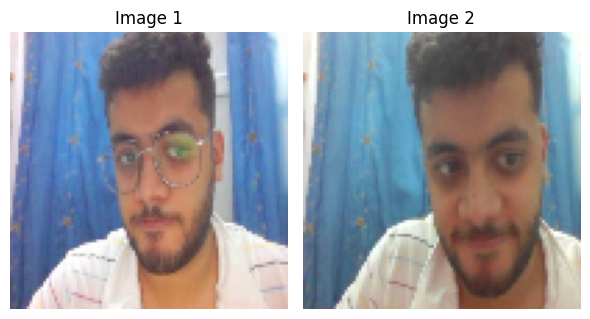

1.0


In [84]:
# Let's say you have two images: img1 and img2 (as numpy arrays)
fig, axes = plt.subplots(1, 2, figsize=(6, 6))  # 2 rows, 1 column

axes[0].imshow(test_input[1])
axes[0].set_title("Image 1")
axes[0].axis("off")

axes[1].imshow(test_val[1])
axes[1].set_title("Image 2")
axes[1].axis("off")



plt.tight_layout()
plt.show()
print(y_true[1])


In [86]:
#save model
siamese_model=siamese_model.save('siamese_model.h5')

In [93]:
print(os.path.exists('siamese_model.h5'))

True


In [95]:
model=tf.keras.models.load_model('siamese_model.h5',custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy' : tf.losses.BinaryCrossentropy})

In [149]:
def real_time_verification(model, detection_threshold=0.5, verification_threshold=0.5):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    verified_text = ''

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        display_frame = frame.copy()
        gray = cv2.cvtColor(display_frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:
            cv2.rectangle(display_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        if 'Verified' in verified_text:
            color = (0, 255, 0)
        elif 'Unverified' in verified_text:
            color = (0, 0, 255)
        else:
            color = (255, 255, 255)

        cv2.putText(display_frame, verified_text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
        cv2.imshow('VERIFICATION', display_frame)

        if cv2.waitKey(10) & 0xFF == ord('v'):
            input_dir = os.path.join('real_time_prediction', 'input_images')
            os.makedirs(input_dir, exist_ok=True)
            input_path = os.path.join(input_dir, 'input_image.jpg')
            cv2.imwrite(input_path, frame)

            input_img = load_and_preprocess_image(input_path)
            results = []

            for image in os.listdir(os.path.join('real_time_prediction', 'verification_images')):
                validation_img = load_and_preprocess_image(
                    os.path.join('real_time_prediction', 'verification_images', image)
                )
                result = model.predict([np.expand_dims(input_img, axis=0),
                                        np.expand_dims(validation_img, axis=0)])
                results.append(result)

            detection = np.sum(np.array(results) > detection_threshold)
            verification = detection / len(results)
            verified = verification > verification_threshold
            verified_text = 'Verified' if verified else 'Unverified'

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [171]:
real_time_verification(model)